<h3> Random Ferns </h3>
Random ferns is an ensemble probabilistic method for classification. 

In optimal Bayesian classifier:

$ H(F) = \underset{k}{argmax} \frac{P(F|c_k)P(c_k)}{P(F)}= \underset{k}{argmax} P(F|c_k)P(c_k)$

where $[F]_{d \times 1}$ is a $d$ dimensional input vector and $P(F|c_k)$ is the probability of $F$ given class label $k$. The problem is calculating $P(F|c_k)$ for high dimensional data (d) is not possible, because:

$P(F|c_k) = P(f_1 | f_2,f_3,...,f_d,c_k) P(f_1, f_2 | f_3,...,f_d,c_k) ... P(f_d| f_1,f_2,...,f_{d-1},c_k)$ 

which its complexity is $O(2^d)$. 
In Naive Bayes method, it is assumed that the features are independent. Under this assumption:

$ P(F|c_k) = P(f_1 |c_k) P(f_2 |c_k) ... P(f_d|c_k) = \prod\limits_{i=1}^{d}P(f_i|c_k)$ 

This assumption is not correct in all cases, specially for data in which features are correlated. For example, in images, each pixel is similar to its neighbors so actually they are not independent. An intermediate approach which asumes that some features are dependent and some features are independent is semi-naive bayes method. In semi-naive bayes, features are partitioned into $L$ non-overlapping subsets. features in each subset are dependent and features of a subset are independent from features of other subsets. In this case:

$P(F|c_k) = \prod\limits_{l=1}^{L} P(F|c_k)$                         
$H(F) = \underset{k}{argmax} P(c_k) \prod\limits_{l=1}^{L}P(F_l|c_k)$

<b>R</b>andom <b>F</b>erns(RFs) is an estimation for semi-naive bayes method. In RFs, estimation of $P(F_l|c_k)$ is done by a set of binary tests. Binary tests are used to estimate feature dependencies. Each fern estimates the conditional probability $P(F_l|c_k)$ based on the features in subset $F_l$. Binary test is simply as follows:

$T(f_i,f_j) = \begin{cases} 1, & \text{if} & f_i > f_j \\ 0, & \text{otherwise} \end{cases} $

applying $\text{S}$ different binary tests leads to a $\text{S}$ bit binary code which can be converted to a decimal number. So, each fern takes an input and produces a number in range $[0, 2^S - 1]$:
<img src="data/temp1.png" width="400" height="200">

In other words, a Fern converts a subset of features to an integer number. For a set of training data from class $c_k$, we feed the input training samples to a fern and get the result. We can make a Histogram by the outputs of the fern.
<img src="data/temp2.png" width="500" height="400">
The obtained histogram is an estimation for $P(F_l | c_k)$.

Here is an implementation of <b>Random Ferns</b> method:

In [24]:
import numpy as np
import random

class Fern(object):
    def __init__(self, features, n_class, code_length):            
        self.F = features
        self.S = code_length
        self.C = n_class
        
        self.Tests = []
        self.Histogram = None 
        self.FITTED = False
        
        passes = 0
        cntr = 0
        while cntr < self.S:
            passes += 1
            if passes > 2**self.S:
                print("Error! It's not possible to make " , 2**self.S , 
                      " different random tests on " , len(self.F) , " smaples...")
                return
            b = random.choices(self.F, k=2)
            if ((b[0],b[1]) in self.Tests) or ((b[1],b[0]) in self.Tests) or (b[0]==b[1]):
                continue
            self.Tests.append((b[0],b[1]))
            cntr += 1
            
    def __str__(self):
        return(str(self.Tests))
    
    def forward(self, x):
        if type(x)==np.ndarray:
            if x.ndim >= 2:
                x = x.flatten()
        
        code = []
        for test in self.Tests:
            if x[test[0]] > x[test[1]]:
                code.append(1)
            else:
                code.append(0)
        
        exp = 1
        decimal = 0
        for b in code:
            decimal = decimal + (exp*b)
            exp = exp*2
        
        return decimal, code
    
    def pdf(self, x):
        if x>2**self.S or x<0:
            print("Error. Invalid Input.")
            return 0
        res = []
        for i in range(self.C):
            res.append(self.Histogram[i,x])
        return res
    
    def fit(self, X, Y):
        self.Histogram = np.zeros((self.C, 2**self.S))
        for (sample,label) in zip(X, Y):
            decimal, _ = self.forward(sample)
            self.Histogram[label, decimal] += 1
        self.FITTED = True


Here we will train some Random Ferns on MNIST dataset.
First of all, we need a method to read <a href="http://yann.lecun.com/exdb/mnist/">MNIST data</a>.
<i>read_mnist</i> function gets paths for MNIST ubyte image file and ubyte label file and returns an array of size $n \times 28 \times 28$, and a list of size $n$.

In [25]:
import numpy as np
import struct

def read_mnist(images_file_path, labels_file_path):
    try:
        with open(labels_file_path , 'rb') as f:
            struct.unpack(">II", f.read(8))
            labels = np.fromfile(f, dtype=np.int8)

        with open(images_file_path, 'rb') as f:
            _,_, rows, cols = struct.unpack(">IIII", f.read(16))
            images = np.fromfile(f, dtype=np.uint8).reshape(len(labels), rows, cols)

        return images, labels    
    except IOError:
        print("Error in reading files.")
            

imgs,lbls = read_mnist("MNIST/t10k-images-idx3-ubyte", "MNIST/t10k-labels-idx1-ubyte")
print("Labels: ", lbls)
print("Images: " , imgs.shape)


Labels:  [7 2 1 ... 4 5 6]
Images:  (10000, 28, 28)


Label of the sample image:  0


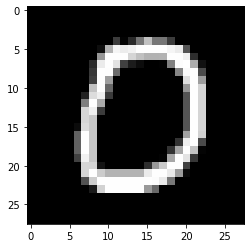

In [26]:
from matplotlib import pyplot as plt

sample_index = 10
im = imgs[sample_index,:,:]
print("Label of the sample image: ", lbls[sample_index])
plt.imshow(im, cmap='gray')
plt.show()

In next step, we will create 20 random ferns and train them on MNIST samples.

In [27]:
# 20 ferns for each class

d = imgs.shape[1]*imgs.shape[2]   # number of features(pixels)
n_classes = 10
n_ferns = 20
code_length = 8   # number of binary tests, or S in formulas

ferns = []
for i in range(n_ferns):
    fern = Fern(features=range(d), n_class=n_classes, code_length=code_length)
    fern.fit(imgs,lbls)
    ferns.append(fern)


For a test sample, we will feed it to all the ferns and get the outputs. Then, a majority voting will be used for the classification:

Input sample:  4
Prediction:  4


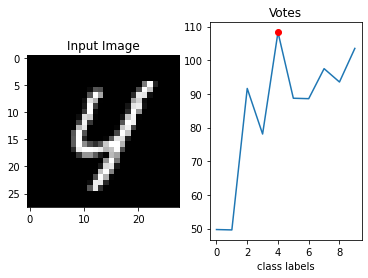

In [28]:
index = 555

print("Input sample: ",lbls[index])
results = []
for fern in ferns:
    x, _ = fern.forward(imgs[index])
    results.append(fern.pdf(x))

results = np.asarray(results)
log_results = np.log(results+1e-6)
p = log_results.sum(axis=0)
a = np.argmax(p)
print("Prediction: " , a)

plt.subplot(1,2,1)
plt.title("Input Image")
plt.imshow(np.asarray(imgs[index,:,:]), cmap='gray')
plt.subplot(1,2,2)
plt.title("Votes")
plt.plot(p)
plt.plot(a,p[a],'ro')
plt.xlabel("class labels")
plt.show()
